<a href="https://colab.research.google.com/github/Manvi1203/EV-Charging/blob/main/EV_Vehicles_Charging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 222 kB in 1s (186 kB/s)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
23 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark


In [ ]:
# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
# install findspark using pip
!pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
sc = spark.sparkContext

In [ ]:
#@title
spark


In [ ]:
# Read JSON file into dataframe
df = spark.read.csv("/content/acn_data_2018_20.csv", header=True, inferSchema=True, multiLine=True)


In [ ]:
df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- clusterID: integer (nullable = true)
 |-- connectionTime: string (nullable = true)
 |-- disconnectTime: string (nullable = true)
 |-- doneChargingTime: string (nullable = true)
 |-- kWhDelivered: double (nullable = true)
 |-- sessionID: string (nullable = true)
 |-- siteID: integer (nullable = true)
 |-- spaceID: string (nullable = true)
 |-- stationID: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userInputs: string (nullable = true)



In [ ]:
import json
import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType

# creating a table with information about charging sessions
charging = df.drop(df["userInputs"])
charging = charging.toPandas()

# creating a table with information about users
user_input_0 = df[['userInputs']]
user_input = user_input_0.na.drop()
rdd = user_input.rdd.map(list)
rdd1 = rdd.flatMap(lambda x: x[0])

# Define the schema for the users DataFrame
schema = StructType([StructField("userId", StringType(), True)])

# Create a DataFrame from the RDD and the schema
users = spark.createDataFrame(rdd1.map(lambda x: (x,)), schema=schema)
users = users.toPandas()

if __name__ == "__main__":
    charging.to_csv('charging.csv')
    users.to_csv('users.csv')
    print ('Files users.csv, charging.csv are created.')


Files users.csv, charging.csv are created.


In [ ]:
charging_to_clean = pd.read_csv('/content/charging.csv')
charging_to_clean['ConnectionTime'] = pd.to_datetime(
    charging_to_clean.connectionTime,
    infer_datetime_format=True)
charging_to_clean['DisconnectTime'] = pd.to_datetime(
    charging_to_clean.disconnectTime,
    infer_datetime_format=True)
charging_to_clean['DoneCharging'] = pd.to_datetime(
    charging_to_clean.doneChargingTime,
    infer_datetime_format=True)
charging = charging_to_clean.drop(
    columns=[
        'connectionTime',
        'disconnectTime',
        'doneChargingTime',
        'Unnamed: 0'])

In [ ]:
charging.dtypes

_id                       object
clusterID                  int64
kWhDelivered             float64
sessionID                 object
siteID                     int64
spaceID                   object
stationID                 object
timezone                  object
userID                   float64
ConnectionTime    datetime64[ns]
DisconnectTime    datetime64[ns]
DoneCharging      datetime64[ns]
dtype: object

In [ ]:
users.dtypes

userId    object
dtype: object

#Analysing Data

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
import plotly.express as px

In [ ]:
def avg_reguest_by_hour(hour, df=users):
    '''
    Calculates average size of charging requests for each hour
    '''
    users_new = users[users.kWhRequested <= 90]
    new_df = users_new[users_new.modifiedAt.dt.hour == hour]
    avg_charge_request = new_df.kWhRequested.mean()

def avg_requests(ls):
    '''
    Calculats avg requests for all hours in the list
    '''
    result = []
    for i in ls:
        result.append(avg_reguest_by_hour(i))
    return result

if __name__ =='__main__':
    users = pd.read_csv('/content/users.csv')
    charging = pd.read_csv('/content/charging.csv')
    hours = list(range(24))

    # prints general information about the dataset
    print(f'''This dataset has information about {users.nunique()}
              unique users and {charging.nunique()} charging sessions.''')
    print(f'''Time period: {charging.connectionTime.max()} -
              {charging.connectionTime.min()}''')

This dataset has information about Unnamed: 0    88232
userId           39
dtype: int64
              unique users and Unnamed: 0          12099
_id                 12099
clusterID               1
connectionTime      12068
disconnectTime      12072
doneChargingTime    12045
kWhDelivered         8221
sessionID           12099
siteID                  1
spaceID                54
stationID              54
timezone                1
userID                 76
dtype: int64 charging sessions.
Time period: Wed, 30 May 2018 23:36:31 GMT -
              Fri, 01 Jun 2018 00:00:40 GMT


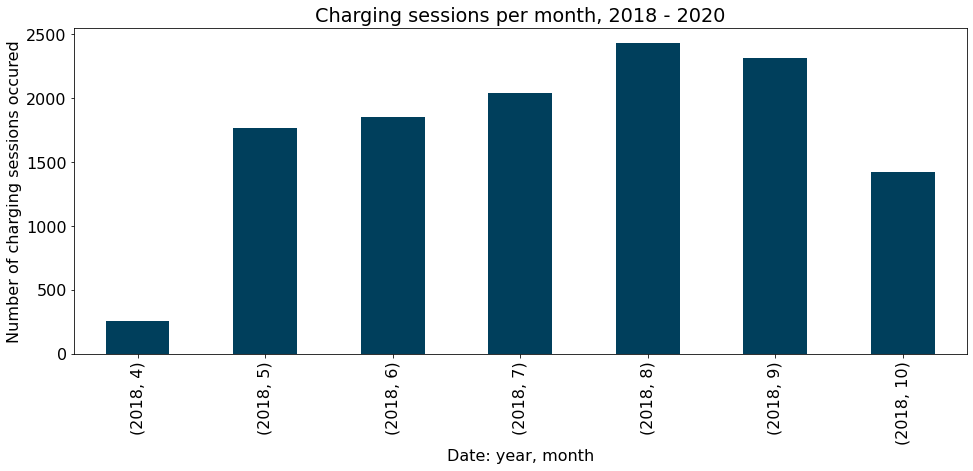

In [ ]:
charging_to_clean = pd.read_csv('/content/charging.csv')
charging_to_clean['ConnectionTime'] = pd.to_datetime(
    charging_to_clean.connectionTime,
    infer_datetime_format=True)
charging_to_clean['DisconnectTime'] = pd.to_datetime(
    charging_to_clean.disconnectTime,
    infer_datetime_format=True)
charging_to_clean['DoneCharging'] = pd.to_datetime(
    charging_to_clean.doneChargingTime,
    infer_datetime_format=True)
charging = charging_to_clean.drop(
    columns=[
        'connectionTime',
        'disconnectTime',
        'doneChargingTime',
        'Unnamed: 0'])
# generates a graph of the total number of charging sessions for each month
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16, 4))
ax = (charging["ConnectionTime"].groupby([charging["ConnectionTime"].dt.year, charging["ConnectionTime"].dt.month]).count().plot(kind="bar", figsize=(16, 6), color="#003f5c"))
ax.set_xlabel('Date: year, month')
ax.set_ylabel('Number of charging sessions occured')
ax.set_title('Charging sessions per month, 2018 - 2020')
plt.savefig("charging_sessions11.png", dpi=500)

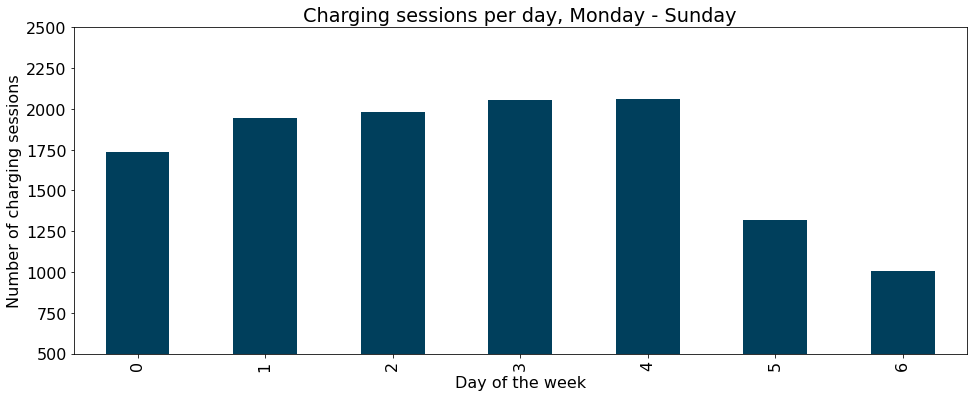

In [ ]:
# generates a graph of the total number
    # of charging sessions for each day of the week
fig, ax = plt.subplots(figsize=(16, 6))
ax = (charging["ConnectionTime"].groupby([
    charging["ConnectionTime"].dt.weekday])
    .count().plot(kind="bar", figsize=(16, 6), color="#003f5c"))
ax.set_xlabel('Day of the week')
ax.set_ylabel('Number of charging sessions')
ax.set_ylim(500, 2500)
ax.set_title('Charging sessions per day, Monday - Sunday')
plt.savefig("charging_sessions12.png", dpi=500)

                clusterID  kWhDelivered  siteID      userID
ConnectionTime                                             
0                    39.0      9.608284     2.0  263.419355
1                    39.0      9.072646     2.0  285.764706
2                    39.0      9.339883     2.0  328.958333
3                    39.0      9.599984     2.0  343.588235
4                    39.0      9.536303     2.0  288.642857
5                    39.0      9.847791     2.0  309.111111
6                    39.0      9.833012     2.0  291.000000
7                    39.0      8.580922     2.0  217.000000
8                    39.0     11.134344     2.0  102.000000
9                    39.0     14.834304     2.0   67.000000
10                   39.0      7.378575     2.0  250.500000
11                   39.0     10.655480     2.0  348.000000
12                   39.0      9.451270     2.0  565.125000
13                   39.0      8.885098     2.0  167.884615
14                   39.0      9.670035 

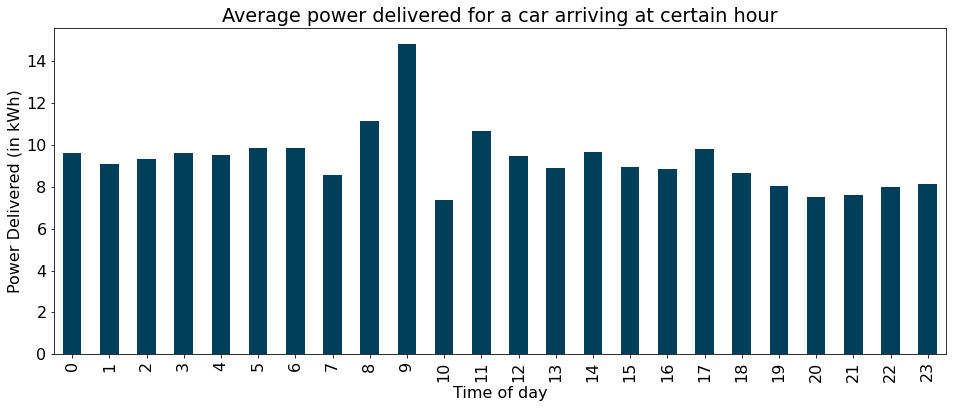

In [ ]:
charging_to_clean = pd.read_csv('/content/charging.csv')
charging_to_clean['ConnectionTime'] = pd.to_datetime(
    charging_to_clean.connectionTime,
    infer_datetime_format=True)
charging_to_clean['DisconnectTime'] = pd.to_datetime(
    charging_to_clean.disconnectTime,
    infer_datetime_format=True)
charging_to_clean['DoneCharging'] = pd.to_datetime(
    charging_to_clean.doneChargingTime,
    infer_datetime_format=True)
charging = charging_to_clean.drop(
    columns=[
        'connectionTime',
        'disconnectTime',
        'doneChargingTime',
        'Unnamed: 0'])
# plotting average length of charging session by the hour of car arrival (start of charging session)
charging_by_hour = charging.groupby(charging["ConnectionTime"].dt.hour).mean()
# print(charging_by_hour["kWhDelivered"])
print(charging_by_hour)
fig, ax = plt.subplots(figsize=(16, 6))
# y = charging_by_hour.time
# x = hours
ax=charging_by_hour["kWhDelivered"].plot(kind="bar",figsize=(16, 6), color="#003f5c")
ax.set_xlabel('Time of day')
ax.set_ylabel('Power Delivered (in kWh)')
ax.set_title('''Average power delivered for a car arriving at certain hour''')
plt.savefig("charging_sessions13.png", dpi=500)